# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




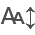

In [56]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [57]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [58]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [59]:
## define SPARQL enpoint
endpoint = "https://ag19e07t386xjtu0.allegrograph.cloud/repositories/astronauts"

In [60]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/Wyrup/astronauts/blob/main/documentation/graphs/wikidata_imported_data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [61]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [62]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

818


[['http://www.wikidata.org/entity/Q118185981',
  'Anastasia Lenkova',
  '1995',
  'female',
  'Belarus',
  'Europe',
  'surgeon, astronaut',
  ''],
 ['http://www.wikidata.org/entity/Q268912',
  'Mary Ellen Weber',
  '1962',
  'female',
  'United States',
  'North America',
  'university teacher, aircraft pilot, chemist, engineer, astronaut',
  ''],
 ['http://www.wikidata.org/entity/Q56725368',
  'Hazza Al Mansouri',
  '1983',
  'male',
  'United Arab Emirates',
  'Asia',
  'astronaut, aircraft pilot, visiting astronaut',
  '']]

In [63]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",


In [64]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [65]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    818 non-null    object
 1   personLabel  818 non-null    object
 2   birthYear    818 non-null    int64 
 3   gender       818 non-null    object
 4   countries    818 non-null    object
 5   continents   818 non-null    object
 6   occupations  818 non-null    object
 7   fields       818 non-null    object
dtypes: int64(1), object(7)
memory usage: 51.3+ KB


In [66]:
### Store to CSV
f_path = 'data/df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [67]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Europe
1    North America
2             Asia
3             Asia
4           Europe
Name: continents, dtype: object


In [68]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                          0
continents                 
North America           440
Europe                  154
Asia, Europe             82
Asia                     80
Europe, Asia             31
Europe, North America    10
Asia, North America       4
South America             3
Oceania                   2
Oceania, North America    2


In [69]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [70]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [71]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia


In [72]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Africa               3
SouthAmerica         3
Oceania              5
Eurasia             31
Asia                80
Europe             250
NorthAmerica       446


In [73]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
5,http://www.wikidata.org/entity/Q3501233,Konstantin Valkov,1971,male,Russia,Europe,"astronaut, explorer",,Europe
7,http://www.wikidata.org/entity/Q555679,Aleksandr Skvortsov,1966,male,Russia,Europe,"aircraft pilot, test cosmonaut, astronaut",,Europe
20,http://www.wikidata.org/entity/Q13519676,Nikolai Tikhonov,1982,male,Russia,Europe,"explorer, astronaut",,Europe
21,http://www.wikidata.org/entity/Q709634,Valery Korzun,1953,male,Russia,Europe,"aircraft pilot, test cosmonaut, astronaut",,Europe
29,http://www.wikidata.org/entity/Q708489,Yury Onufriyenko,1961,male,"Ukraine, Russia",Europe,"aircraft pilot, test cosmonaut, astronaut",,Europe
37,http://www.wikidata.org/entity/Q465724,Anatoly Berezovoy,1942,male,"Soviet Union, Russia","Asia, Europe","aircraft pilot, astronaut",,Europe
39,http://www.wikidata.org/entity/Q975217,Sergey Revin,1966,male,Russia,Europe,"explorer, engineer, astronaut",,Europe


In [74]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia         30
Europe         122


In [75]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q357510,Mark Kelly,1964,male,United States,North America,"naval aviator, politician, naval officer, writ...",gun control,NorthAmerica
98,http://www.wikidata.org/entity/Q461840,Jing Haipeng,1966,male,People's Republic of China,Asia,"aircraft pilot, fighter pilot, astronaut",,Asia
99,http://www.wikidata.org/entity/Q48998,Susan Kilrain,1961,female,United States,North America,"astronaut, United States Naval Aviator, test p...",,NorthAmerica
100,http://www.wikidata.org/entity/Q471486,Viktor Afanasyev,1948,male,"Soviet Union, Russia","Asia, Europe","aircraft pilot, military personnel, astronaut",,Europe


In [76]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
111,http://www.wikidata.org/entity/Q265261,Janet L. Kavandi,1959,female,United States,North America,"chemist, astronaut",,NorthAmerica
112,http://www.wikidata.org/entity/Q17593757,Alexander Jabloncev,1955,male,"Russia, Soviet Union","Europe, Asia",astronaut,,Eurasia
113,http://www.wikidata.org/entity/Q460440,William R. Pogue,1930,male,United States,North America,"autobiographer, aircraft pilot, military offic...",,NorthAmerica
114,http://www.wikidata.org/entity/Q1904202,Martin J. Fettman,1956,male,United States,North America,"veterinarian, astronaut",,NorthAmerica
115,http://www.wikidata.org/entity/Q507894,Andy Thomas,1951,male,"Australia, United States","Oceania, North America","engineer, astronaut",,Oceania
116,http://www.wikidata.org/entity/Q2720489,John Barron McKay,1922,male,United States,North America,"military flight engineer, astronaut, aircraft ...",,NorthAmerica
117,http://www.wikidata.org/entity/Q447304,Rex J. Walheim,1962,male,United States,North America,"military officer, engineer, astronaut",,NorthAmerica


In [77]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  758 

0    http://www.wikidata.org/entity/Q118185981
1       http://www.wikidata.org/entity/Q268912
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",,Asia
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",,Europe


### Distribution des continents: représentation graphique

In [78]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Africa,3,0.37
SouthAmerica,3,0.37
Oceania,5,0.61
Eurasia,31,3.79
Asia,80,9.78
Europe,250,30.56
NorthAmerica,446,54.52


In [79]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,NorthAmerica,Europe,Asia,Eurasia,Oceania,SouthAmerica,Africa
frequence,54.52,30.56,9.78,3.79,0.61,0.37,0.37


In [80]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


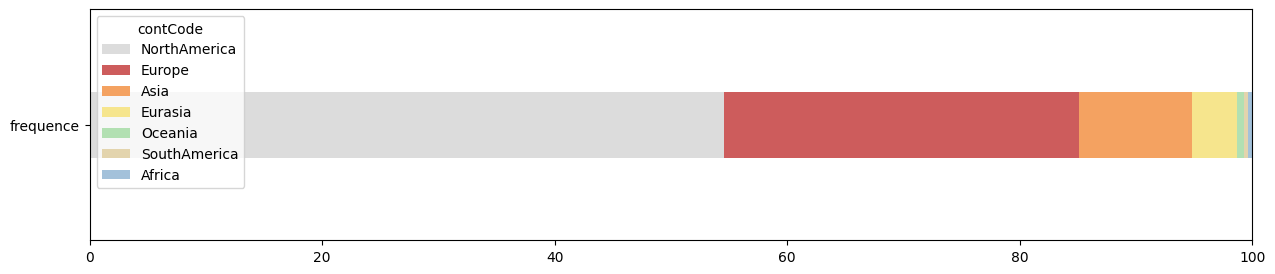

In [81]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [90]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1875, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1875, 1900, 1925, 1950, 1975] [1900, 1925, 1950, 1975, 2000] 5


In [91]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [92]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia,1975-1999


In [94]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1900-1924     12
1925-1949    293
1950-1974    380
1975-1999    132
dtype: int64


### Comparer période et continent

In [88]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,0,0,0,2,10,0,0,12
1925-1949,1,9,14,99,168,2,0,293
1950-1974,2,31,12,104,226,2,3,380
1975-1999,0,39,5,45,42,1,0,132
Total,3,79,31,250,446,5,3,817


In [89]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,2,0,10,0,0,0,0,12
1925-1949,99,14,168,9,1,2,0,293
1950-1974,104,12,226,31,2,2,3,380
1975-1999,45,5,42,39,0,1,0,132
Total,250,31,446,79,3,5,3,817


In [95]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


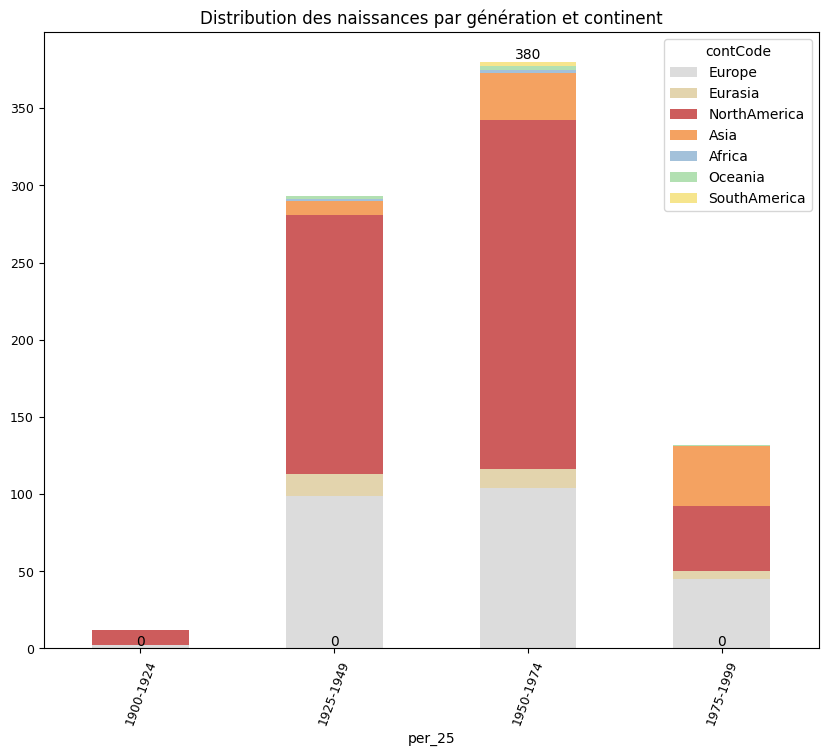

In [96]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [97]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,2,0,10,0,0,0,0,12
1925-1949,99,14,168,9,1,2,0,293
1950-1974,104,12,226,31,2,2,3,380
1975-1999,45,5,42,39,0,1,0,132
Total,250,31,446,79,3,5,3,817


In [98]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1975-1999,45,5,42,39,0,1,0
Total,250,31,446,79,3,5,3


In [99]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 7 ), effectif: 949 , nombre max. facteurs: 1


In [100]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 49.02 , dof : 6
p-value : 7.394944812855023e-09
phi2 = inertie (variance totale) : 0.051652083289097074
Cramer:  0.22727094686540353


In [101]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1975-1999,41,5,68,16,0,1,0
Total,254,31,420,102,3,5,3


In [102]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1975-1999,45,5,42,39,0,1,0
Total,250,31,446,79,3,5,3


In [103]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1975-1999       4        0           -26    23       0        0             0
Total          -4        0            26   -23       0        0             0


In [104]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1975-1999,0.62,-0.0,-3.14,5.58,-0.65,0.18,-0.65
Total,-0.25,0.0,1.26,-2.24,0.26,-0.07,0.26


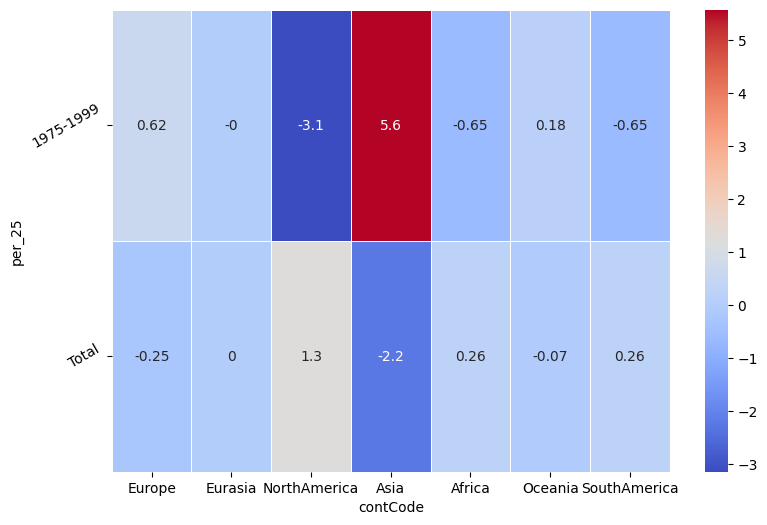

In [105]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [106]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1975-1999,5,42,39,0,1,0
Total,31,446,79,3,5,3


In [107]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 50.22 , dof : 5
p-value : 1.2474466634292932e-09
phi2 = inertie (variance totale) : 0.05292222702849559
Cramer:  0.27711707593871426


In [108]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1975-1999,45,39,5,42,0
Total,250,79,31,446,3


In [109]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 0.0 , dof : 1
p-value : 1.0
phi2 = inertie (variance totale) : 0.0
Cramer:  0.011870460897334196


## Continent et genre

In [110]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia,1975-1999
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",,Asia,1950-1974
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",,Europe,1950-1974


In [111]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,0,13,8,20,73,0,0,114
male,3,67,23,230,373,5,3,704
Total,3,80,31,250,446,5,3,818


### Créer la fonction

In [112]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [113]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,0,13,8,20,73,0,0
male,3,67,23,230,373,5,3


Chi2 : 15.32 , dof : 6
p-value : 0.017885243264628026
phi2 = inertie (variance totale) : 0.016146877748104728
Cramer:  0.13686762554718138


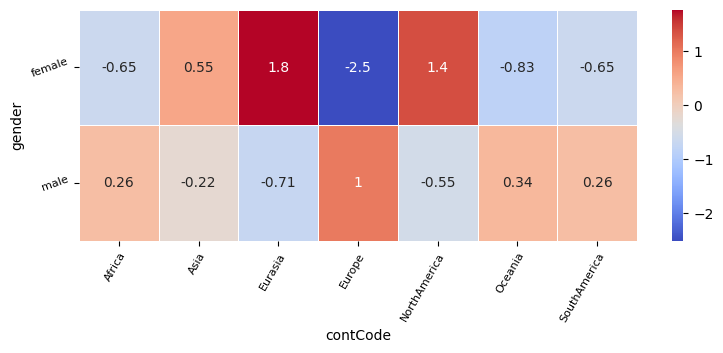

In [114]:
bivariee_stats(D)

### Genre et continent par époque

In [115]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",,Europe,1950-1974,Europe_female


In [116]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_male,SouthAmerica_male,Total
per_25,,,,,,,,,,,,
1900-1924,0,0,0,0,0,0,2,0,10,0,0,12
1925-1949,1,0,9,6,8,2,97,11,157,2,0,293
1950-1974,2,5,26,0,12,7,97,42,184,2,3,380
1975-1999,0,8,31,2,3,11,34,20,22,1,0,132
Total,3,13,66,8,23,20,230,73,373,5,3,817


In [121]:
### Limiter à la période significative, 20 siècle
periodes_20e = ['1900-1924', '1925-1949', '1950-1974', '1975-1999']
D = ddgcp.loc[periodes_20e, ddgcp.columns[:-1]].copy(deep=True)
D


genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_male,SouthAmerica_male
per_25,,,,,,,,,,,
1900-1924,0,0,0,0,0,0,2,0,10,0,0
1925-1949,1,0,9,6,8,2,97,11,157,2,0
1950-1974,2,5,26,0,12,7,97,42,184,2,3
1975-1999,0,8,31,2,3,11,34,20,22,1,0


Chi2 : 161.66 , dof : 30
p-value : 5.521895621720479e-20
phi2 = inertie (variance totale) : 0.17035232706853445
Cramer:  0.25682392909165525


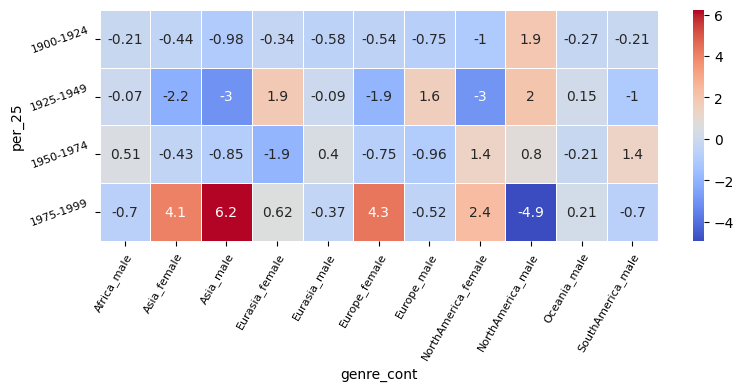

In [122]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [123]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

20


In [124]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
Germany                                          3
Russia                                           3
United Kingdom                                   2
Soviet Union, Russia                             2
France                                           2
France, Italy                                    1
Belgium                                          1
Belarus                                          1
Austria                                          1
New Zealand, United Kingdom, Italy, Australia    1
dtype: int64


In [125]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

Series([], dtype: int64)


In [126]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

0


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont


## Continent et discipline

In [127]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",,Europe,1950-1974,Europe_female


In [139]:
def code_discipline(col1, col2):
    if  'aircraft pilot' in col1\
        or 'aircraft pilot' in col2:
        output = 'army'
    elif 'university teacher' in col1\
        or 'university teacher' in col2:
        output = 'school'
    else:
        output = 'other'
    return output    


In [140]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974,NorthAmerica_female,army
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,"astronaut, aircraft pilot, visiting astronaut",,Asia,1975-1999,Asia_male,army
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,"fighter pilot, astronaut",,Asia,1950-1974,Asia_male,other
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,"politician, astronaut, physician",,Europe,1950-1974,Europe_female,other


In [142]:
df_p.groupby('code_discipline').size()

code_discipline
army      248
other     545
school     25
dtype: int64

In [143]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
army,1,15,5,103,124,0,0,248
other,2,65,26,139,305,5,3,545
school,0,0,0,8,17,0,0,25
Total,3,80,31,250,446,5,3,818


In [144]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
army,0.4,6.0,2.0,41.5,50.0,0.0,0.0,100.0
other,0.4,11.9,4.8,25.5,56.0,0.9,0.6,100.0
school,0.0,0.0,0.0,32.0,68.0,0.0,0.0,100.0
Total,0.4,9.8,3.8,30.6,54.5,0.6,0.4,100.0


In [145]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


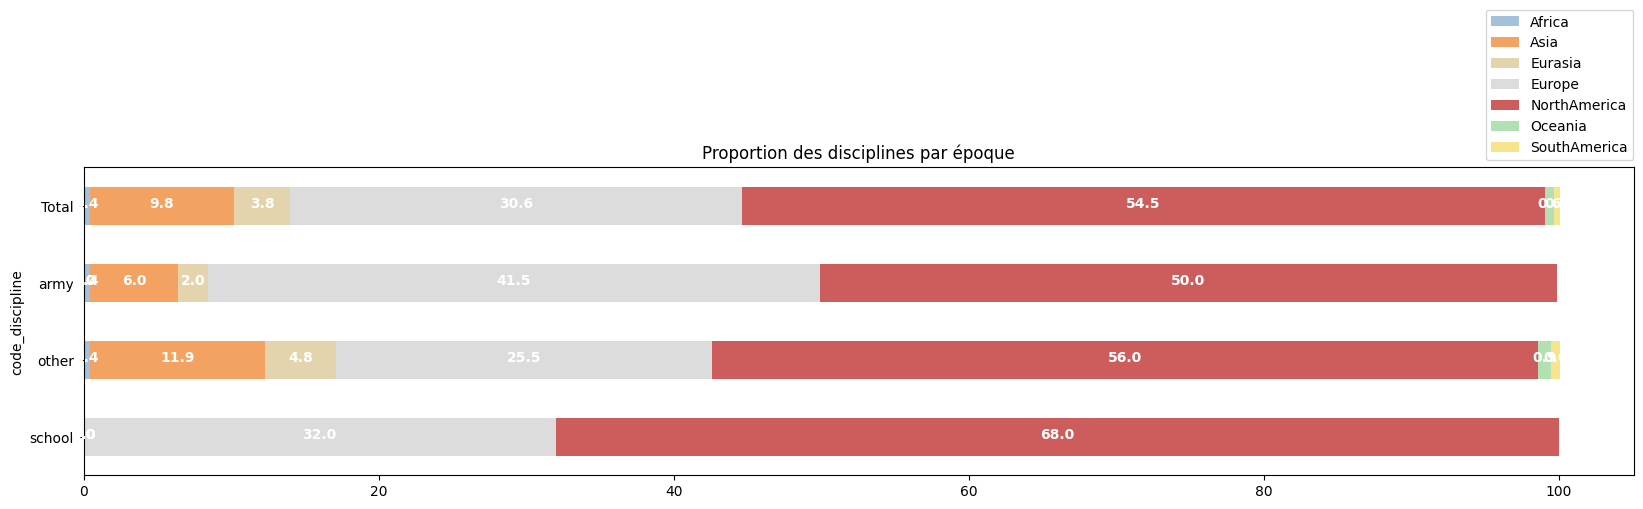

In [146]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [147]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
army,1,15,5,103,124,0,0
other,2,65,26,139,305,5,3
school,0,0,0,8,17,0,0


Chi2 : 33.36 , dof : 12
p-value : 0.0008516179823019002
phi2 = inertie (variance totale) : 0.035148443436601735
Cramer:  0.1427889187530477


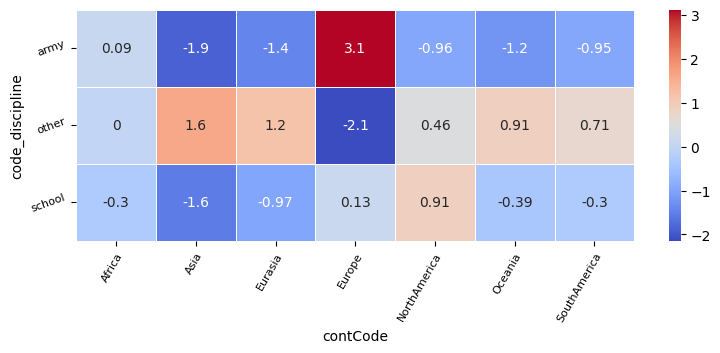

In [148]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [149]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974,NorthAmerica_female,army


In [150]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,"surgeon, astronaut",,Europe,1975-1999,Europe_female,other,Europe_other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,"university teacher, aircraft pilot, chemist, e...",,NorthAmerica,1950-1974,NorthAmerica_female,army,NorthAmerica_army


In [151]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_army,Africa_other,Asia_army,Asia_other,Eurasia_army,Eurasia_other,Europe_army,Europe_other,Europe_school,NorthAmerica_army,NorthAmerica_other,NorthAmerica_school,Oceania_other,SouthAmerica_other,Total
per_25,,,,,,,,,,,,,,,
1900-1924,0,0,0,0,0,0,2,0,0,6,4,0,0,0,12
1925-1949,0,1,1,8,2,12,52,44,3,77,83,8,2,0,293
1950-1974,1,1,9,22,3,9,39,60,5,36,181,9,2,3,380
1975-1999,0,0,4,35,0,5,10,35,0,5,37,0,1,0,132
Total,1,2,14,65,5,26,103,139,8,124,305,17,5,3,817


In [154]:
### Limiter à la période significative, 20 siècle
periodes_20e = ['1900-1924', '1925-1949', '1950-1974', '1975-1999']
D = dddcp.loc[periodes_20e, dddcp.columns[:-1]].copy(deep=True)
D

disc_cont,Africa_army,Africa_other,Asia_army,Asia_other,Eurasia_army,Eurasia_other,Europe_army,Europe_other,Europe_school,NorthAmerica_army,NorthAmerica_other,NorthAmerica_school,Oceania_other,SouthAmerica_other
per_25,,,,,,,,,,,,,,
1900-1924,0,0,0,0,0,0,2,0,0,6,4,0,0,0
1925-1949,0,1,1,8,2,12,52,44,3,77,83,8,2,0
1950-1974,1,1,9,22,3,9,39,60,5,36,181,9,2,3
1975-1999,0,0,4,35,0,5,10,35,0,5,37,0,1,0


Chi2 : 183.92 , dof : 39
p-value : 1.103494266023088e-20
phi2 = inertie (variance totale) : 0.19380000089644395
Cramer:  0.27392920554299927


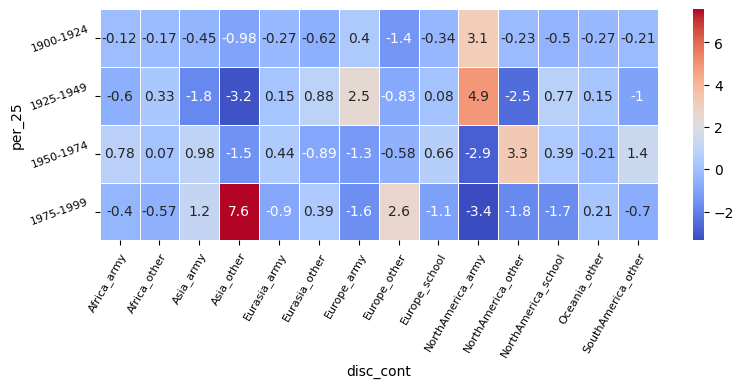

In [155]:
## Appliquer la fonction
bivariee_stats(D)